In [1]:
import pandas as pd
import numpy as np

In [20]:
aspm77 = dataset.aspm77
throughput_grouped = dataset.throughput

In [10]:
df = pd.read_csv('../data/1993_2023_CA.csv')
df['quarter_id'] = (df['Year']-1993)*4 + df['Quarter'] 
ca_airport = df[df['OriginState'] == 'CA']['Origin'].unique()

df = df[['Origin', 'Dest', 'Passengers','quarter_id']]
df['Passengers'] = (df['Passengers']*10).astype(int)

number_of_quarters = df.groupby('Origin')['quarter_id'].nunique().sort_values(ascending=False).reset_index()
selected_airports_from_od = number_of_quarters[number_of_quarters['quarter_id'] >= 124]['Origin'].values


ca_airport = set(ca_airport).intersection(aspm77.values()).intersection(set(selected_airports_from_od))
selected_airports = set(selected_airports_from_od).intersection(aspm77.values())

df = df[(df['Origin'].isin(selected_airports)) & (df['Dest'].isin(selected_airports))].reset_index(drop=True)


In [17]:
training_x_start_quarter = 36
prediction_horizon_size = 12
training_length = 20

training_x_end_quarter = training_x_start_quarter+training_length
training_y_start_quarter = training_x_end_quarter
training_y_end_quarter = training_y_start_quarter+prediction_horizon_size

testing_x_start_quarter = training_x_start_quarter+prediction_horizon_size
testing_x_end_quarter = testing_x_start_quarter+training_length
testing_y_start_quarter = testing_x_end_quarter
testing_y_end_quarter = testing_y_start_quarter+prediction_horizon_size



In [18]:
quarters_required_in_od = np.arange(training_x_start_quarter, testing_x_end_quarter)
quarters_required_in_throughput = np.arange(training_x_start_quarter, testing_y_end_quarter)

In [232]:
# od_selected = df[df['quarter_id'].isin(quarters_required_in_od)]
# od_selected_cnt = od_selected.groupby(['Origin', 'Dest'])['quarter_id'].nunique().reset_index()

In [21]:
throughput_selected = throughput_grouped[throughput_grouped['quarter_id'].isin(quarters_required_in_throughput)]
throughput_selected_cnt = throughput_selected.groupby(['Facility'])['quarter_id'].nunique().reset_index()
qualified_airports = throughput_selected_cnt[throughput_selected_cnt['quarter_id'] >= len(quarters_required_in_throughput)]['Facility'].values

In [22]:

qualified_ca_airports = set(qualified_airports).intersection(ca_airport)
print('Number of airports in the network:', len(qualified_airports))
print('The airports in the network are:', qualified_airports)
print('Number of California airports in the network:', len(qualified_ca_airports))
print('The Californian airports in the network are:', qualified_ca_airports)

qualified_airports = {index: value for index, value in enumerate(qualified_airports)}
qualified_ca_airports = {index: value for index, value in enumerate(qualified_ca_airports)}

qualified_airports_inverse = {value: index for index, value in qualified_airports.items()}
qualified_ca_airports_inverse = {value: index for index, value in qualified_ca_airports.items()}


Number of airports in the network: 55
The airports in the network are: ['ABQ' 'ATL' 'BDL' 'BNA' 'BOS' 'BUR' 'BWI' 'CLE' 'CLT' 'CVG' 'DAL' 'DAY'
 'DCA' 'DEN' 'DFW' 'DTW' 'EWR' 'FLL' 'HNL' 'HOU' 'HPN' 'IAD' 'IAH' 'IND'
 'JFK' 'LAS' 'LAX' 'LGA' 'MCI' 'MCO' 'MDW' 'MEM' 'MIA' 'MSP' 'MSY' 'OAK'
 'ONT' 'ORD' 'PBI' 'PDX' 'PHL' 'PHX' 'PIT' 'RDU' 'SAN' 'SAT' 'SDF' 'SEA'
 'SFO' 'SJC' 'SJU' 'SLC' 'STL' 'TEB' 'TPA']
Number of California airports in the network: 7
The Californian airports in the network are: {'BUR', 'ONT', 'LAX', 'SFO', 'OAK', 'SAN', 'SJC'}


In [469]:
def build_xy(
    x_start_quarter, 
    x_end_quarter, 
    y_start_quarter, 
    y_end_quarter, 
    qualified_airports, 
    qualified_airports_inverse,
    qualified_ca_airports,
    qualified_ca_airports_inverse
):
    num_edges = len(qualified_ca_airports) * (len(qualified_airports)-1) * 2

    x_nodes = np.empty((x_end_quarter-x_start_quarter, len(qualified_airports), 1), dtype=int)
    x_edges_all = np.empty((x_end_quarter-x_start_quarter, num_edges, 2), dtype=int)
    x_edge_attr_all = np.empty((x_end_quarter-x_start_quarter, num_edges, 1), dtype=int)
    y = np.empty((len(qualified_ca_airports), y_end_quarter-y_start_quarter))

    for q_id in range(x_start_quarter, x_end_quarter):
        x_edges = np.empty((1,2), dtype=int)
        x_edge_attr = np.empty((1,1), dtype=int)

        df_q_id = df[(df['quarter_id'] == q_id)]
        df_q_id = df_q_id[df_q_id['Origin'].isin(qualified_airports.values())]
        df_q_id = df_q_id[df_q_id['Dest'].isin(qualified_airports.values())].reset_index(drop=True)
        throughput_q_id = throughput_selected[throughput_selected['quarter_id'] == q_id]

        for node_index in range(len(qualified_airports)):
            try:
                x_nodes[q_id-x_start_quarter, node_index, 0] = throughput_q_id[throughput_q_id['Facility'] == qualified_airports[node_index]]['total_throughput'].values[0]
            except IndexError:
                x_nodes[q_id-x_start_quarter, node_index, 0] = 0

        for origin in qualified_ca_airports.values():
            for dest in qualified_airports.values():
                if origin != dest:
                    x_edges = np.concatenate((x_edges, [[qualified_airports_inverse[origin], qualified_airports_inverse[dest]]]), axis=0)
                    try:
                        passengers = df_q_id[(df_q_id['Origin'] == origin) & (df_q_id['Dest'] == dest)]['Passengers'].values[0]
                        x_edge_attr = np.concatenate((x_edge_attr, [[passengers]]), axis=0)
                    except IndexError:
                        x_edge_attr = np.concatenate((x_edge_attr, [[0]]), axis=0)

        for origin in qualified_airports.values():
            for dest in qualified_ca_airports.values():
                if origin != dest:
                    x_edges = np.concatenate((x_edges, [[qualified_airports_inverse[origin], qualified_airports_inverse[dest]]]), axis=0)
                    try:
                        passengers = df_q_id[(df_q_id['Origin'] == origin) & (df_q_id['Dest'] == dest)]['Passengers'].values[0]
                        x_edge_attr = np.concatenate((x_edge_attr, [[passengers]]), axis=0)
                    except IndexError:
                        x_edge_attr = np.concatenate((x_edge_attr, [[0]]), axis=0)

        x_edges = np.delete(x_edges, 0, axis=0)
        x_edge_attr = np.delete(x_edge_attr, 0, axis=0)

        x_edges_all[q_id-x_start_quarter] = x_edges
        x_edge_attr_all[q_id-x_start_quarter] = x_edge_attr

    for q_id in range(y_start_quarter, y_end_quarter):
        throughput_q_id = throughput_selected[throughput_selected['quarter_id'] == q_id]
        for ca_airport in qualified_ca_airports.values():
            throughput = throughput_q_id[throughput_q_id['Facility'] == ca_airport]['total_throughput'].values[0]
            y[qualified_ca_airports_inverse[ca_airport], q_id-y_start_quarter] = throughput

    return x_nodes, x_edges_all, x_edge_attr_all, y

In [468]:
qualified_ca_airports

{0: 'OAK', 1: 'BUR', 2: 'SAN', 3: 'SFO', 4: 'ONT', 5: 'LAX', 6: 'SJC'}

In [471]:
a,b,c,d = build_xy(training_x_start_quarter, 
                 training_x_end_quarter, 
                 training_y_start_quarter, 
                 training_y_end_quarter, 
                 qualified_airports, 
                 qualified_airports_inverse, 
                 qualified_ca_airports,
                 qualified_ca_airports_inverse)

In [ ]:
x_train [[q1,q2,q3,..,q20]]


y<- throughput

In [264]:
# Node features for each graph: shape [num_nodes, num_node_features]
x = torch.tensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])

# Edge index for each graph: shape [2, num_edges]
edge_index = torch.tensor([[0, 1], [1, 2]])  # Directed edges: 0->1 and 1->2

# Edge features for each graph: shape [num_edges, num_edge_features]
edge_attr = torch.tensor([[0.1], [0.2]])

# Output for each graph: shape [num_nodes, output_dim]
output = torch.tensor([[1.0], [2.0], [3.0]])  # Assuming a scalar output for each node


NameError: name 'torch' is not defined

In [ ]:
nodes = np.empty((77,1))
for i in range(77):
    nodes[i] = df_q_id[(df_q_id['origin'] == self.aspm_77[i]) or (df_q_id['destination'] == self.aspm_77[i])]['passengers'].sum()

In [89]:
data_aval = throughput_grouped.groupby('Facility')['quarter_id'].count().reset_index()
throughput_grouped.groupby('Facility')['quarter_id'].count().sort_values(ascending=False)
data_aval[data_aval['quarter_id'] != 104]

,Facility,quarter_id
1,ANC,77
3,AUS,77
5,BHM,77
8,BUF,77
9,BUR,96
14,DAL,96
22,GYY,77
23,HNL,96
29,ISP,77
30,JAX,77


25

In [ ]:
# Node features for each graph: shape [num_nodes, num_node_features]
x = torch.tensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])

# Edge index for each graph: shape [2, num_edges]
edge_index = torch.tensor([[0, 1], [1, 2]])  # Directed edges: 0->1 and 1->2

# Edge features for each graph: shape [num_edges, num_edge_features]
edge_attr = torch.tensor([[0.1], [0.2]])

# Output for each graph: shape [num_nodes, output_dim]
output = torch.tensor([[1.0], [2.0], [3.0]])  # Assuming a scalar output for each node

In [1]:
import os
os.chdir('code/')
from dataset import AirportDataset

In [2]:
dataset = AirportDataset([1,1998], 
                         batch_length=8, 
                         n_train_samples=24, 
                         n_test_samples=12, 
                         prediction_horizon=4)

Number of airports in the network: 49
The airports in the network are: ['ABQ' 'ATL' 'BDL' 'BNA' 'BOS' 'BWI' 'CLE' 'CLT' 'CVG' 'DAY' 'DCA' 'DEN'
 'DFW' 'DTW' 'EWR' 'FLL' 'HOU' 'HPN' 'IAD' 'IAH' 'IND' 'JFK' 'LAS' 'LAX'
 'LGA' 'MCI' 'MCO' 'MDW' 'MEM' 'MIA' 'MSP' 'MSY' 'ONT' 'ORD' 'PBI' 'PDX'
 'PHL' 'PHX' 'PIT' 'RDU' 'SAN' 'SAT' 'SEA' 'SFO' 'SJC' 'SJU' 'SLC' 'STL'
 'TPA']
Number of California airports in the network: 5
The Californian airports in the network are: {'SFO', 'SJC', 'SAN', 'ONT', 'LAX'}
Building training set


100%|██████████| 24/24 [00:15<00:00,  1.59it/s]


Building testing set


100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


In [3]:
from dgl.data import DGLDataset
import dgl
import numpy as np
import torch

In [30]:
class AirportGraph():
    def __init__(self, nodes, edges, edge_attr, y):
        self.nodes = nodes
        self.edges = edges
        self.edge_attr = edge_attr
        self.y = y

    def process(self):
        self.series = []
        self.y_transformed = np.empty(shape=(len(self.y), self.y[0].shape[0]*self.y[0].shape[1]))

        for series in range(len(self.nodes)):
            node_sample = self.nodes[series]
            edge_sample = self.edges[series]
            edge_attr_sample = self.edge_attr[series]

            list_of_graphs = []
        
            for graph in range(node_sample.shape[0]):
                transformed_edges = edge_sample[graph].T
                g = dgl.graph(
                    (torch.LongTensor(transformed_edges[0]), torch.LongTensor(transformed_edges[1]))
                )
                
                g.ndata["x"] = torch.tensor(node_sample[graph]).float()
                g.edata["weight"] = torch.tensor(edge_attr_sample[graph]).float()


                list_of_graphs.append(g)

            self.series.append(list_of_graphs)
        
            self.y_transformed[series] = self.y[series].flatten()
        
        self.y_transformed = torch.tensor(self.y_transformed).float()



In [31]:
a = AirportGraph(nodes=dataset.train_x_nodes, 
                 edges=dataset.train_x_edges, 
                 edge_attr=dataset.train_x_edges_attr,
                 y=dataset.train_y)
a.process()

from dgl.nn import EdgeGATConv
import torch.nn as nn
import torch.nn.functional as F
from model import DeepAir
from train import train_model

In [32]:



model = DeepAir(len(dataset.qualified_ca_airports), prediction_horizon=dataset.prediction_horizon)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
model(a.series).shape

torch.Size([24, 20])

## PATTERN

In [208]:
test_y = np.load('test_y.npy')
test_y_predicted = np.load('test_y_predicted.npy')

test_y_predicted =test_y_predicted.reshape(test_y.shape)

In [209]:
train_y = np.load('train_y.npy')
train_y_predicted = np.load('train_y_predicted.npy')
train_y_predicted = train_y_predicted.reshape(train_y.shape)

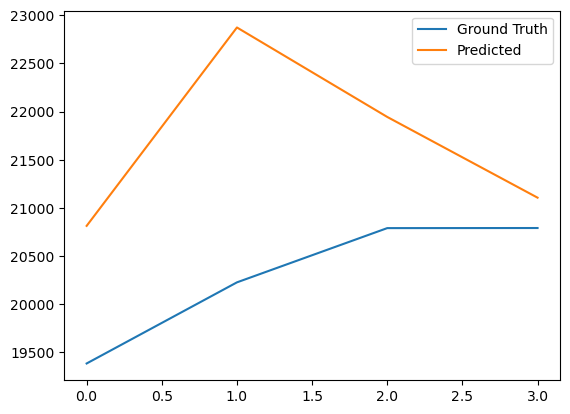

In [220]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(train_y[0,3,:], label='Ground Truth')
ax.plot(train_y_predicted[0,3,:], label='Predicted')
# ax.set(ylim=(0, 160000))
ax.legend()


[(0.0, 100000.0)]

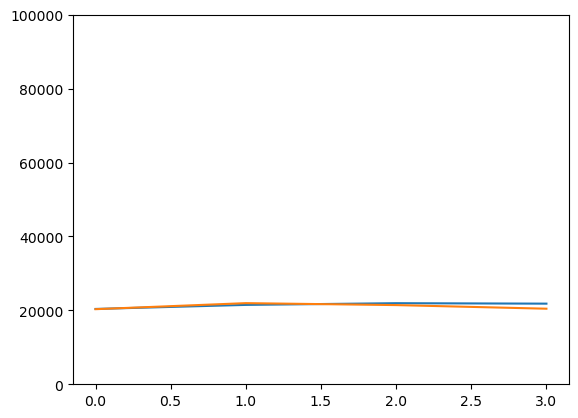

In [222]:
fig, ax = plt.subplots()
ax.plot(train_y[4,3,:], label='Ground Truth')
ax.plot(train_y_predicted[4,3,:], label='Predicted')
ax.plot(title='train set')
ax.set(ylim=(0, 100000))

(0.0, 100000.0)

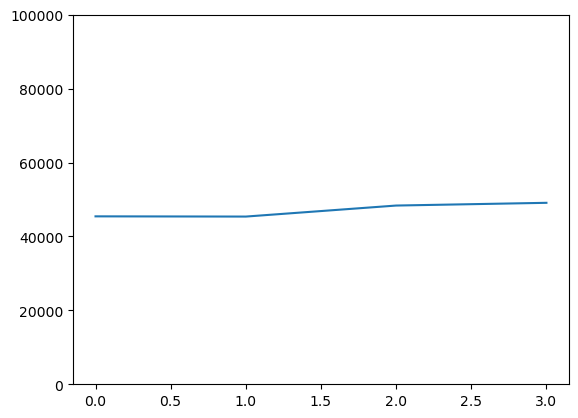

In [164]:
plt.plot(train_y[0,0,:])
plt.ylim(0, 100000)

In [49]:
import os
os.chdir('code/')
from dataset import AirportDataset
os.chdir('../')
dataset = AirportDataset(training_start_quarter=[1,1998], 
                            batch_length=8, 
                            n_train_samples=48, 
                            n_test_samples=12, 
                            prediction_horizon=4)

Number of airports in the network: 49
The airports in the network are: ['ABQ' 'ATL' 'BDL' 'BNA' 'BOS' 'BWI' 'CLE' 'CLT' 'CVG' 'DAY' 'DCA' 'DEN'
 'DFW' 'DTW' 'EWR' 'FLL' 'HOU' 'HPN' 'IAD' 'IAH' 'IND' 'JFK' 'LAS' 'LAX'
 'LGA' 'MCI' 'MCO' 'MDW' 'MEM' 'MIA' 'MSP' 'MSY' 'ONT' 'ORD' 'PBI' 'PDX'
 'PHL' 'PHX' 'PIT' 'RDU' 'SAN' 'SAT' 'SEA' 'SFO' 'SJC' 'SJU' 'SLC' 'STL'
 'TPA']
Number of California airports in the network: 5
The Californian airports in the network are: {'LAX', 'SFO', 'SJC', 'ONT', 'SAN'}
Building training set


100%|██████████| 48/48 [00:29<00:00,  1.61it/s]


Building testing set


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


In [54]:
np.exp(dataset.train_y)[47]

array([[141351., 138632., 144770., 149413.],
       [ 96706.,  93651., 102408., 107170.],
       [ 25110.,  24394.,  25662.,  25953.],
       [ 17815.,  16527.,  16719.,  16583.],
       [ 42534.,  41152.,  43752.,  45395.]])

In [58]:
test_y[0]

array([[ 96229., 105727., 108439., 102572.],
       [ 41912.,  45177.,  47644.,  45391.],
       [143034., 153138., 158627., 152062.],
       [ 26086.,  28049.,  29170.,  27763.],
       [ 15690.,  16272.,  16181.,  17131.]])

In [87]:
comb_array = np.array(list(combinations))

In [88]:
comb_array.shape

(1048569, 20)